In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from tqdm import tqdm

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2, T = 100):
        """
        input_dim: dimension of input (x and t concatenated)
        output_dim: dimension of output (drift term)
        """
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 32, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.time_emb = nn.Embedding(T, 32)
    
    def forward(self, x, t):
        """
        x: Tensor of shape (batch_size, 2)
        t: Tensor of shape (batch_size, 1)
        """
        # Concatenate x and t
        # print(x.shape, self.time_emb(t).shape)
        xt = torch.cat([x, self.time_emb(t)], dim=-1)  # Shape: (batch_size, 3)
        return self.net(xt)

In [3]:
class SchrödingerBridgeDataset(Dataset):
    def __init__(self, initial_samples: int, final_samples: int):
        """
        Args:
            initial_samples (int): Number of samples from the initial distribution.
            final_samples (int): Number of samples from the final distribution.
        """
        super(SchrödingerBridgeDataset, self).__init__()
        
        self.initial_data = self.uniform_distribution(final_samples)
        # self.final_data = self.uniform_distribution(initial_samples) + 2
        self.final_data = self.bimodal_distribution(final_samples)
        random_index = torch.randperm(len(self.final_data))
        self.final_data = self.final_data[random_index, :]
    @staticmethod
    def uniform_distribution(batch_size: int) -> torch.Tensor:
        """
        Uniform distribution in [-1, 1] x [-1, 1].
        """
        return torch.rand(batch_size, 1) * 2 - 1  # Shape: (batch_size, 2)
    
    @staticmethod
    def bimodal_distribution(batch_size: int) -> torch.Tensor:
        """
        Bimodal distribution with two Gaussian clusters.
        """
        half = batch_size // 2
        cluster1 = torch.randn(half, 1) + 2.0  # Cluster centered at (2)
        cluster2 = torch.randn(batch_size - half, 1) - 2.0  # Cluster centered at (-2)
        return torch.cat([cluster1, cluster2], dim=0)  # Shape: (batch_size, 1)
    
    def __len__(self):
        # Total samples are from both initial and final distributions
        return max(len(self.initial_data), len(self.final_data))
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns a tuple of (x_initial, x_final).
        If one distribution has fewer samples, wrap around using modulo.
        """
        x_initial = self.initial_data[idx % len(self.initial_data)]
        x_final = self.final_data[idx % len(self.final_data)]
        return {"x0": x_initial, "xT":x_final}
    def plot(self):
        bins = np.linspace(-5, 5, 100)
        plt.hist(self.initial_data.detach().numpy(), bins = bins, alpha = 0.3, label = "inital_distribution")
        plt.hist(self.final_data.detach().numpy(), bins = bins, alpha = 0.3, label = "final_distribution")
        plt.legend()
        plt.grid()
        plt.show()
        

In [4]:
def lagevin(x:torch.Tensor, model:nn.Module, T:int, sigma:torch.Tensor, device = "cuda:0", reversed = False):
    traj_x = [x.unsqueeze(-1).detach().cpu()]
    grad_all = []
    model.eval()
    model.to(device)
    t = np.arange(0, T)
    sigma = sigma.to(device)
    xk = x
    for i in t:
        time = torch.full((xk.shape[0],), fill_value = i).to(device)
        xk = xk.to(device)
        xk = xk + model(xk, time) + torch.sqrt(2*sigma[i]).squeeze(-1)*torch.randn_like(xk, device = device, dtype=torch.float32)
        traj_x.append(xk.unsqueeze(-1).detach().cpu())
        grad_all.append(traj_x[-1] - traj_x[-2])
    x_all = torch.cat(traj_x, dim = -1)
    grad_all = torch.cat(grad_all, dim = -1)
    return x_all, grad_all

In [18]:
def linear_process(x0, xT, T, sigma, inverse = False, device = "cuda:0"):
    x_all = []
    grad_all = []
    x0, xT = x0.to(device), xT.to(device)
    xk = x0.unsqueeze(-1)
    # x0_temp = x0.unsqueeze(-1).to(device)
    # xT_temp = xT.unsqueeze(-1).to(device)
    
    x_all.append(xk.detach().cpu())
    for i in range(1,T+1):
        mu_i = (xT.unsqueeze(-1) - x0.unsqueeze(-1))/T
        # print(xk.shape)
        xk  = xk.to(device)
        xk = xk +  mu_i + torch.sqrt(2*sigma[i-1]).squeeze(-1)*torch.randn_like(mu_i).to(device)
        xk = xk.detach().cpu()
        x_all.append(xk)
        # print(x_all[-1].shape, x_all[-2].shape)
        grad_all.append((x_all[-1] - x_all[-2]))
    return torch.cat(x_all, dim = -1), torch.cat(grad_all, dim = -1)

In [19]:
def simple_dsb(dataset, batch_size, epoches, inner_epoches, f_model, b_model,f_optim, b_optim, sigma, T, device):
    dl = DataLoader(dataset=dataset, batch_size=batch_size)
    inner_pbar = tqdm(range(inner_epoches), desc=f"inner epoch", leave=True)
    outer_pbar = tqdm(range(epoches), desc=f"Epoch", leave=False)
    sigma = sigma.to(device)
    total_loss_f = []
    f_model.train()
    b_model.eval()
    f_model, b_model = f_model.to(device), b_model.to(device)
    for inner_epoch in inner_pbar:
        epoch_loss_f = 0
        
        for data in dl:
            x0, xT = data['x0'].to(device), data["xT"].to(device)
            x_all, grad_all = linear_process(x0, xT, T = T, sigma=sigma, device=device)
            # print(x_all.shape, grad_all.shape)
            x_all, grad_all = x_all[..., :-1].to(device), grad_all.to(device)
            sample_t = torch.randint(high = T-1, low = 0, dtype= torch.int64, size = (x0.shape[0], 1, 1), device = device)
            sample_xk = torch.gather(x_all, dim = -1, index = sample_t).to(device)
            grad_out = torch.gather(grad_all, dim = -1, index = sample_t).to(device)
            pred_out = f_model(sample_xk, sample_t.squeeze(-1))
            f_optim.zero_grad()
            loss_f = nn.functional.mse_loss(input = pred_out, target= grad_out)
            loss_f.backward()
            torch.nn.utils.clip_grad_norm_(f_model.parameters(), 1)
            f_optim.step()
            epoch_loss_f += loss_f.item()
        inner_pbar.set_postfix({"inner_epoch":inner_epoch, "forward_loss": epoch_loss_f/len(dl)})
        total_loss_f.append(epoch_loss_f/len(dl))
    plt.plot(total_loss_f)
    plt.show()
    return f_model

inner epoch:   0%|          | 0/30 [00:00<?, ?it/s]

inner epoch: 100%|██████████| 30/30 [00:03<00:00,  9.31it/s, inner_epoch=29, forward_loss=0.000245]


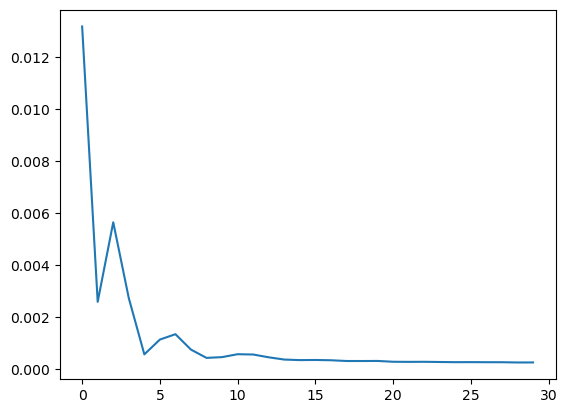

In [20]:
ds = SchrödingerBridgeDataset(10000, 10000)
T = 100
f_model = MLP(1, 256, 1, T)
b_model = MLP(1, 256, 1, T)
f_optim = torch.optim.Adam(f_model.parameters())
b_optim = torch.optim.Adam(b_model.parameters())
device = "cuda:0"
# sigma = torch.from_numpy(np.concatenate([np.linspace(0, 1, int(T/2))*1e-1, (np.linspace(0, 1, int(T/2))[::-1])*1e-1])).unsqueeze(-1).to(torch.float32)
sigma = torch.ones((T, 1))*1e-5
# print(sigma.shape)
f_model = simple_dsb(dataset=ds, batch_size=5000, epoches = 10, inner_epoches=30, f_model = f_model, b_model = b_model, f_optim = f_optim, b_optim = b_optim, sigma = sigma, T = T, device = device)


In [21]:
x0 = next(iter(DataLoader(ds, batch_size = 1000)))['x0']
xT = next(iter(DataLoader(ds, batch_size = 1000)))['xT']
x_generate, score_generate = lagevin(x0, f_model, T, sigma = sigma, device = device)
x_generate = x_generate.numpy()
x_ou, score_ou = linear_process(x0, xT, T, sigma, False, device = device)

In [22]:
print(x_generate.shape)

(1000, 1, 101)


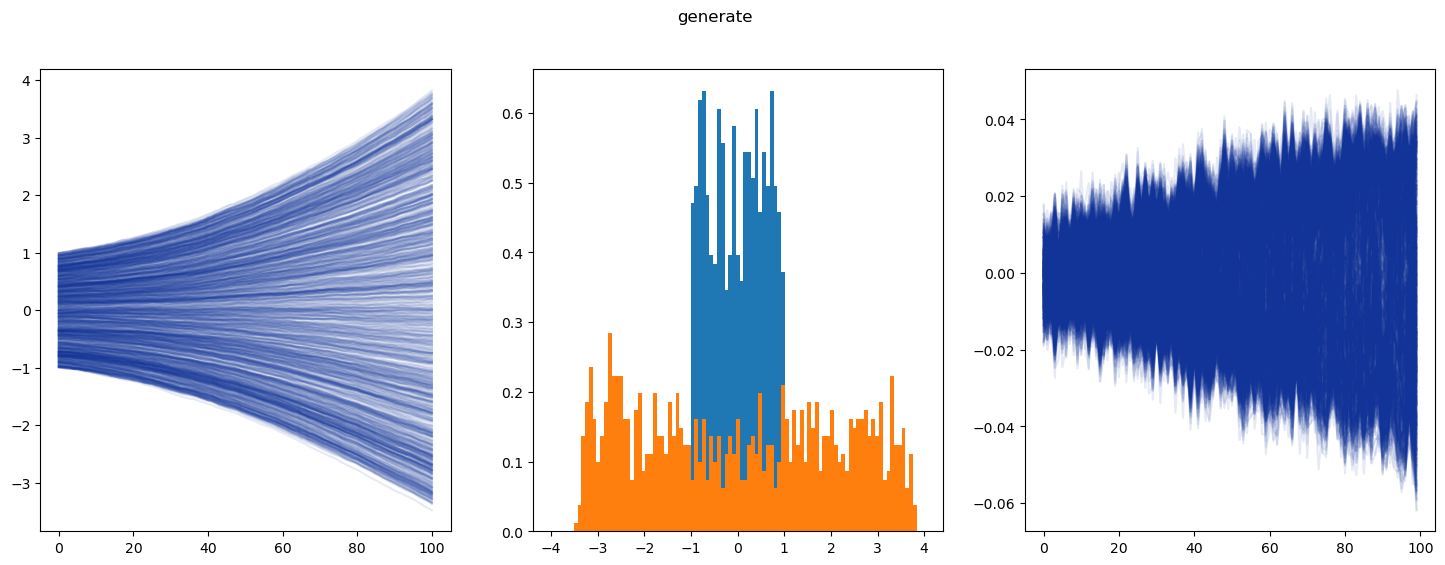

In [23]:
bins = np.linspace(-4, 4, 100)
fig, ax = plt.subplots(1,3, figsize = (6*3, 6))
for i in range(0, len(x_ou)):
    ax[0].plot(x_generate[i, 0, :], color = "#123499", alpha = 0.1)
ax[1].hist(x_generate[:, 0, 0], bins = bins, density= True)
ax[1].hist(x_generate[:, 0, -1], bins = bins, density=True)
for i in range(0, len(x_ou)):
    ax[2].plot(score_generate[i, 0, :], color = "#123499", alpha = 0.1)
fig.suptitle("generate")
plt.show()

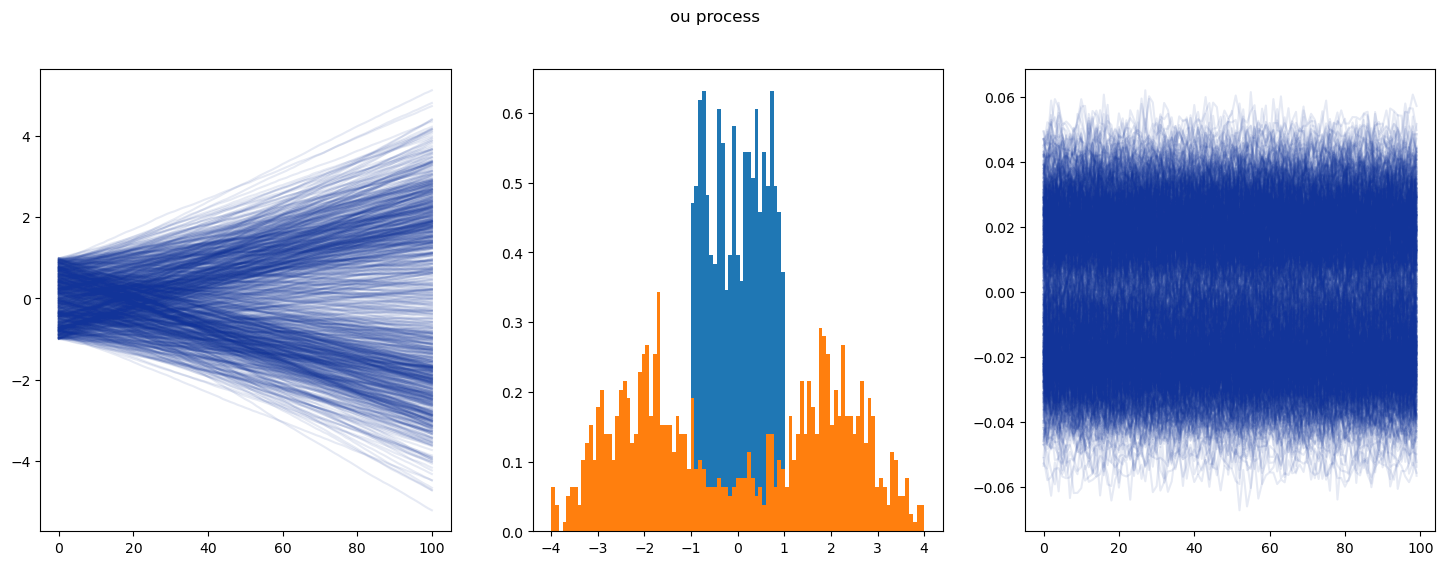

In [24]:
bins = np.linspace(-4, 4, 100)
fig, ax = plt.subplots(1,3, figsize = (6*3, 6))
for i in range(0, len(x_ou)):
    ax[0].plot(x_ou[i, 0, :], color = "#123499", alpha = 0.1)
ax[1].hist(x_ou[:, 0, 0], bins = bins, density= True)
ax[1].hist(x_ou[:, 0, -1], bins = bins, density=True)
for i in range(0, len(x_ou)):
    ax[2].plot(score_ou[i, 0, :], color = "#123499", alpha = 0.1)
fig.suptitle("ou process")
plt.show()